In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
higgs_small = np.load('/Users/linggeli/Other/workshop/higgs_small.npy')
print(higgs_small.shape)

(100000, 29)


In [3]:
dataX = higgs_small[:, 1:]
dataY = higgs_small[:, 0].reshape((100000, 1))

In [4]:
N, D = dataX.shape
print(N, D)

(100000, 28)


In [5]:
from sklearn import preprocessing

In [6]:
dataX = preprocessing.scale(dataX)

Split the data into training and test sets.

In [7]:
train_size = int(N * 0.7)
test_size = N - train_size
rand_ind = np.random.permutation(N) # shuffle the row indices
train_ind = rand_ind[:train_size]
test_ind = rand_ind[train_size:]

In [8]:
X_train = dataX[train_ind, :]
X_test = dataX[test_ind, :]
y_train = dataY[train_ind, :]
y_test = dataY[test_ind, :]

In [9]:
print(y_train.shape)
print(y_test.shape)

(70000, 1)
(30000, 1)


In [10]:
X = tf.placeholder("float", shape=[None, D])
y = tf.placeholder("float", shape=[None, 1])

i. How would you change the activation function?  
ii. How would you change the number of neurons?  
iii. How would you add more layers?  
iv. How would you use drop-out or weight penalty for regularization?

In [11]:
# first hidden layer
W1 = tf.Variable(tf.random_normal([D, 50], stddev=1.0))
b1 = tf.Variable(tf.random_normal([1, 50], stddev=1.0))
h1 = tf.nn.sigmoid(tf.matmul(X, W1) + b1)

W2 = tf.Variable(tf.random_normal([50, 20], stddev=1.0))
b2 = tf.Variable(tf.random_normal([1, 20], stddev=1.0))
h2 = tf.nn.sigmoid(tf.matmul(h1, W2) + b2)

W3 = tf.Variable(tf.random_normal([20, 20], stddev=1.0))
b3 = tf.Variable(tf.random_normal([1, 20], stddev=1.0))
h3 = tf.nn.sigmoid(tf.matmul(h2, W3) + b3)

W4 = tf.Variable(tf.random_normal([20, 5], stddev=1.0))
b4 = tf.Variable(tf.random_normal([1, 5], stddev=1.0))
h4 = tf.nn.sigmoid(tf.matmul(h3, W4) + b4)

#d = tf.nn.dropout(h2, 0.5)

# output layer
W5 = tf.Variable(tf.random_normal([5, 1], stddev=1.0))
b5 = tf.Variable(tf.random_normal([1, 1], stddev=1.0))
yhat = tf.nn.sigmoid(tf.matmul(h4, W5) + b5)

Binary classification loss function

In [12]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=yhat))

In [13]:
def accuracy(y_true, y_pred):
    """
    Calculate classification accuracy.
    
    Args
        y_true: (2d numpy array) [n_example, 1]
        y_pred: (2d numpy array) [n_example, 1]
    """
    return(np.mean(y_true[:, 0] == (y_pred[:, 0] > 0.5)))

Model training

In [14]:
batch_size = 20
step_size = 1.0

n_epochs = 50
n_batch = y_train.shape[0] / batch_size

In [15]:
updates = tf.train.GradientDescentOptimizer(step_size).minimize(loss)

In [16]:
train_acc = []
test_acc = []
test_pred = 0
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for k in range(n_epochs):
        for i in range(0, n_batch):
            # generate batch data
            offset = (i * batch_size) % (y_train.shape[0] - batch_size)
            batch_data = X_train[offset:(offset + batch_size), :]
            batch_labels = y_train[offset:(offset + batch_size), :]
            # stochastic gradient descent
            sess.run(updates, feed_dict={X: batch_data, y: batch_labels})
        train_pred = sess.run(yhat, feed_dict={X: X_train})
        test_pred = sess.run(yhat, feed_dict={X: X_test})
        train_acc.append(accuracy(y_train, train_pred))
        test_acc.append(accuracy(y_test, test_pred))

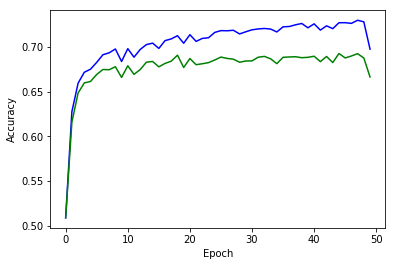

In [17]:
fig = plt.figure(figsize=(6, 4))
plt.plot(train_acc, c='blue')
plt.plot(test_acc, c='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [18]:
from sklearn import metrics

In [19]:
fpr, tpr, thresholds = metrics.roc_curve(y_test[:, 0], test_pred[:, 0], pos_label=1)

In [20]:
print(metrics.auc(fpr, tpr))

0.747637974754


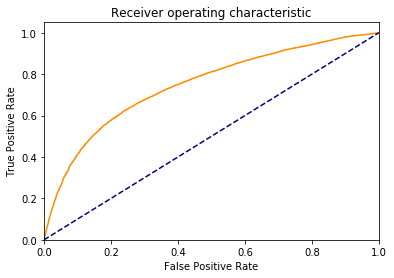

In [21]:
fig = plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()